# Channel  Quality Assessment, Pruning, and Motion Artifact Detection: Example Notebook (WIP)

This notebook sketches how to prune bad channels and detect motion artefacts in fNIRS data

In [19]:
import cedalion
import cedalion.nirs
import cedalion.sigproc.quality as quality
import cedalion.xrutils as xrutils
import cedalion.datasets as datasets
import xarray as xr
import matplotlib.pyplot as p
from functools import reduce
import numpy as np

from cedalion import Quantity, units

# include matplotlib widget support in jupyter
%matplotlib widget

### Loading raw CW-NIRS data from a SNIRF file and converting it to OD and CONC

This notebook uses a finger-tapping dataset in BIDS layout provided by Rob Luke that is automatically fetched. 
You can also find it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping).

(28, 2, 23239)

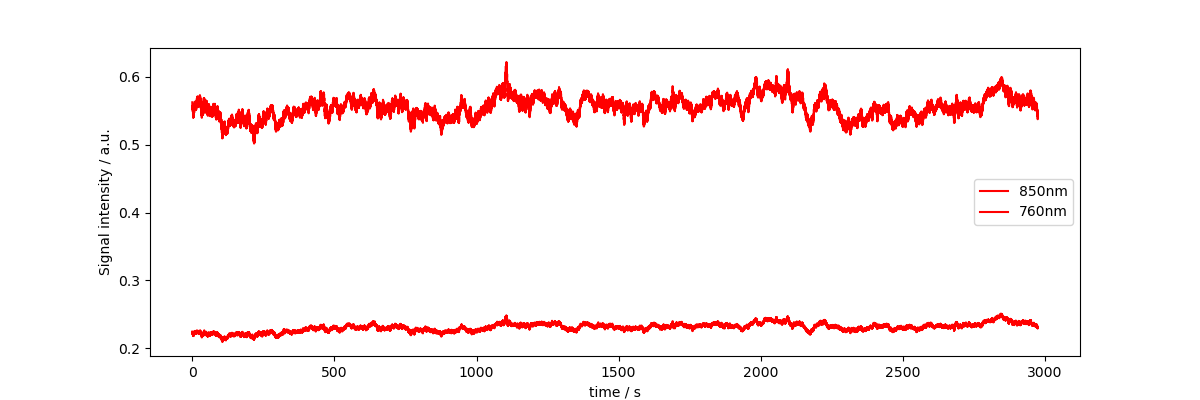

In [20]:
# get example finger tapping dataset

snirf_element = datasets.get_fingertapping()
amp = snirf_element[0].data[0]
geo = snirf_element[0].geo3d
od = cedalion.nirs.int2od(amp)
# ml = snirf_element[0].measurement_lists[0]

data = xr.Dataset(
    data_vars = {
        "amp" : amp,
        "od"  : od,
        "geo3d": geo
    })


# Plot some data for visual validation
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( data.amp.time, data.amp.sel(channel="S3D3", wavelength="850"), "r-", label="850nm")
ax.plot( data.amp.time, data.amp.sel(channel="S3D3", wavelength="760"), "r-", label="760nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

amp.shape

# Calculating Signal Quality Metrics and applying Masks

To assess channel quality metrics such as SNR, channel distances, average amplitudes, sci, and others, we use small helper functions. 
These should also be provided with thresholds for these metrics and will feed back both the metrics and a mask to apply later on, e.g. for channel pruning.
The input and output arguments are therefore always based on xarray time series and parameters and instructions for thresholding. 
The mask is a boolean array in the shape and size of the input time series. It  indicates where the threshold for our quality metric was passed ("True") and is False otherwise.
This mask can be combined with other masks, for instance, to combine metrics to prune channels. At any point in time, the mask can be applied using the "apply_mask()" function available from cedalion's the xrutils package. 

If you are a user who is mainly interested in high-level application, you can skip to the Section "***Channel Pruning using Quality Metrics and the Pruning Function***" below. The "prune_ch()" function provides a higher abstraction layer to simply prune your data, using the same metrics and functions that are demonstrated below. 
 

### Channel Quality Metrics: SNR

In [21]:
# Here we assess channel quality by SNR
snr_thresh = 16 # the SNR (std/mean) of a channel. Set high here for demonstration purposes

# SNR thresholding using the "snr" function of the quality subpackage
snr, snr_mask = quality.snr(data.amp, snr_thresh)

# apply mask function. In this example, we want all signals with an SNR below the threshold to be replaced with "nan". 
# We do not want to collapse / combine any dimension of the mask (last argument: "none")
data_masked_snr_1, masked_elements_1 = xrutils.apply_mask(data.amp, snr_mask, "nan", "none")

# alternatively, we can "drop" all channels with an SNR below the threshold. Since the SNR of both wavelength might differ
# (pass the threshold for one wavelength, but not for the other), we collapse to the "channel" dimension.
data_masked_snr_2, masked_elements_2 = xrutils.apply_mask(data.amp, snr_mask, "drop", "channel")

# show some results
print(f"channels that were masked according to the SNR threshold: {masked_elements_2}")
# nan-masked:
# data_masked_snr_1

# dropped:
data_masked_snr_2


mask collapsed to channel dimension
channels that were masked according to the SNR threshold: ['S4D4' 'S5D7' 'S6D8' 'S8D8']


Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.187484 0.1868235 0.1866562 ... 0.1735965 0.1736705 0.1738339] [0.2424386 0.241503 0.2408491 ... 0.22303 0.2229887 0.2234081]] [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,volt


### Channel Quality Metrics: Channel Distance

In [22]:
# Here we assess channel distances. We might want to exclude very short or very long channels
sd_threshs = [1, 4.5]*units.cm # defines the lower and upper bounds for the source-detector separation that we would like to keep

# Source Detector Separation thresholding
ch_dist, sd_mask = quality.sd_dist(data.amp, data.geo3d, sd_threshs)
# print the channel distances
print(f"channel distances are: {ch_dist}")

# apply mask function. In this example, we want to "drop" all channels that do not fall inside sd_threshs 
# i.e. drop channels shorter than 1cm and longer than 4.5cm. We want to collapse along the "channel" dimension.
data_masked_sd, masked_elements = xrutils.apply_mask(data.amp, sd_mask, "drop", "channel")

# display the resultings
print(f"channels that were masked according to the SD Distance thresholds: {masked_elements}")
data_masked_sd

channel distances are: <xarray.DataArray 'geo3d' (channel: 28)>
<Quantity([0.039 0.039 0.041 0.008 0.037 0.038 0.037 0.007 0.04  0.037 0.008 0.041
 0.034 0.008 0.039 0.039 0.041 0.008 0.037 0.037 0.037 0.008 0.04  0.037
 0.007 0.041 0.033 0.008], 'meter')>
Coordinates:
  * channel   (channel) object 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
    source    (channel) object 'S1' 'S1' 'S1' 'S1' 'S2' ... 'S7' 'S8' 'S8' 'S8'
    detector  (channel) object 'D1' 'D2' 'D3' 'D9' ... 'D15' 'D7' 'D8' 'D16'
mask collapsed to channel dimension
channels that were masked according to the SD Distance thresholds: ['S1D9' 'S2D10' 'S3D11' 'S4D12' 'S5D13' 'S6D14' 'S7D15' 'S8D16']


Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0941083 0.0940129 0.0944882] [0.1856806 0.186377 0.1836514 ... 0.1856486 0.1850836 0.1842172]] [[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] ... [[0.2225884 0.2187791 0.2195495 ... 0.2564863 0.2551258 0.2560233] [0.3994258 0.3917637 0.389261 ... 0.4304597 0.430814 0.4331249]] [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]]]
Units,volt


### Channel Quality Metrics: Mean Amplitudes

In [23]:
# Here we assess average channel amplitudes. We might want to exclude very small or large signals
amp_threshs = [0.1, 3]*units.volt # define whether a channel's amplitude is within a certain range


# Amplitude thresholding
mean_amp, amp_mask = quality.mean_amp(data.amp, amp_threshs)

# apply mask function. In this example, we want drop all channels that do not fall inside the amplitude thresholds. 
# We collapse to the "channel" dimension.
data_masked_amp, masked_elements = xrutils.apply_mask(data.amp, amp_mask, "drop", "channel")

# display the results
print(f"channels that were masked according to the amplitude threshold: {masked_elements}")
data_masked_amp


mask collapsed to channel dimension


channels that were masked according to the amplitude threshold: ['S1D1' 'S1D9' 'S3D2' 'S6D8' 'S7D6']


Magnitude,[[[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] [[0.5512474 0.5510672 0.5476283 ... 0.6179242 0.6188702 0.6187721] [1.125532 1.1238331 1.1119423 ... 1.1817728 1.1819598 1.1832658]] ... [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]] [[0.4885007 0.4802285 0.4818338 ... 0.6109142 0.6108118 0.613845] [0.8457658 0.825988 0.8259648 ... 0.975894 0.9756599 0.9826459]] [[0.6304559 0.6284427 0.6287045 ... 0.6810626 0.6809573 0.6818709] [1.2285622 1.2205907 1.2190002 ... 1.2729124 1.2727222 1.2755645]]]
Units,volt


### Channel Pruning using Quality Metrics and the Pruning Function

To prune channels according to quality criteria, we do not have to manually go through the steps above. Instead, we can create quality masks for the metrics that we are interested in and hand them to a dedicated channel pruning function. The prune function expects a list of quality masks alongside a logical operator that defines how these masks should be combined.

In [24]:
# as above we use three metrics and define thresholds accordingly
snr_thresh = 16 # the SNR (std/mean) of a channel. 
sd_threshs = [1, 4.5]*units.cm # defines the lower and upper bounds for the source-detector separation that we would like to keep
amp_threshs = [0.1, 3]*units.volt # define whether a channel's amplitude is within a certain range

# then we calculate the masks for each metric: SNR, SD distance and mean amplitude
_, snr_mask = quality.snr(data.amp, snr_thresh)
_, sd_mask = quality.sd_dist(data.amp, data.geo3d, sd_threshs)
_, amp_mask = quality.mean_amp(data.amp, amp_threshs)

# put all masks in a list
masks = [snr_mask, sd_mask, amp_mask]

# prune channels using the masks and the operator "all", which will keep only channels that pass all three metrics
amp_pruned, drop_list = quality.prune_ch(data.amp, masks, "all")

# print list of dropped channels
print(f"List of pruned channels: {drop_list}")
# display the new data xarray
amp_pruned

mask collapsed to channel dimension
List of pruned channels: ['S1D1' 'S1D9' 'S2D10' 'S3D2' 'S3D11' 'S4D4' 'S4D12' 'S5D7' 'S5D13' 'S6D8'
 'S6D14' 'S7D6' 'S7D15' 'S8D8' 'S8D16']


Magnitude,[[[0.227516 0.2297024 0.2261366 ... 0.2264519 0.2271665 0.226713] [0.6354927 0.637668 0.6298023 ... 0.6072068 0.6087293 0.6091066]] [[0.1064704 0.1066212 0.1053444 ... 0.121114 0.1205022 0.1205441] [0.2755033 0.2761615 0.2727006 ... 0.2911952 0.2900544 0.2909847]] [[0.5512474 0.5510672 0.5476283 ... 0.6179242 0.6188702 0.6187721] [1.125532 1.1238331 1.1119423 ... 1.1817728 1.1819598 1.1832658]] ... [[0.3463254 0.3424951 0.3408207 ... 0.3929267 0.3941368 0.3945422] [0.6978315 0.6875081 0.6857653 ... 0.7259991 0.7271688 0.7292138]] [[0.2225884 0.2187791 0.2195495 ... 0.2564863 0.2551258 0.2560233] [0.3994258 0.3917637 0.389261 ... 0.4304597 0.430814 0.4331249]] [[0.2027881 0.1996586 0.2004866 ... 0.2318743 0.2311941 0.2330808] [0.4666358 0.4554404 0.4561614 ... 0.4809749 0.4812827 0.4862896]]]
Units,volt


## Motion Artefact Detection (!!WIP!!)
The same xarray-based masks can be used for indicating motion-artefacts. The example below shows how to checks channels for motion artefacts using standard thresholds from Homer2/3. The output is a mask that can be handed to motion correction algorithms

Explore results

c:\Users\avonl\anaconda3\envs\cedalion\lib\site-packages\xarray\core\variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


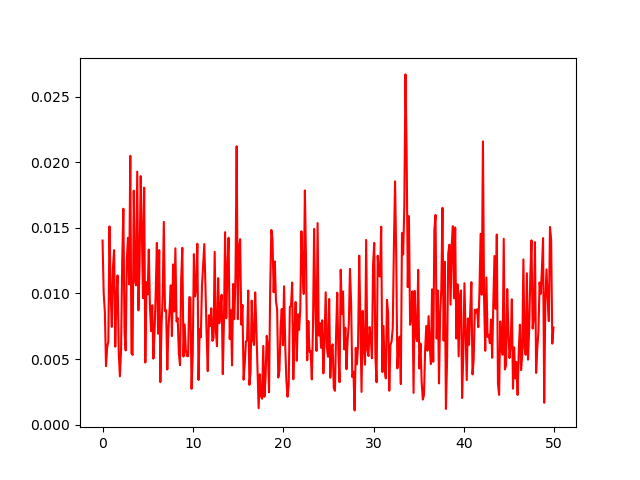

In [27]:
# Plot some data for visual validation
""" f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot(od.time, od.sel(channel="S3D3", wavelength="760"), "r-", label="S3D3 - 850nm")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("OD / a.u.")
 """

fNIRSdata = data.od
# Coming soon


t_motion = 0.5*units.s
t_mask = 1.0*units.s
stdev_thresh = 5.0
amp_thresh = 5.0
global_flag = False


channel_mask = xrutils.mask(fNIRSdata, True)

# calculate the "std_diff", the standard deviation of the approx 1st derivative of
# each channel over time
std_diff = fNIRSdata.diff(dim="time").std(dim="time")

# calculate max_diff for each channel for different time delays

#t_motion in samples rounded to the nearest sample, recast as int
t_motion_samples = t_motion / fNIRSdata.time.diff(dim="time").mean()
t_motion_samples = int(t_motion_samples.round())

# calculate the differences across different time shifts from 1 to t_motion_samples
diff = []
for ii in range(1, t_motion_samples):
    # Shift the data by X samples to the left in the 'time' dimension
    shifted_data = fNIRSdata.shift(time=-ii,fill_value=0)
    # zero padding of original data where shifted data is shorter
    fNIRSdata0 =fNIRSdata.copy()
    strt_zeroidx = fNIRSdata0.time[-ii]
    fNIRSdata0.loc[dict(time=slice(strt_zeroidx, None))] = 0
    # calc differences
    diff.append(abs(fNIRSdata - shifted_data))

# concatenate the list of xarrays into a single xarray along a new dimension called "diff"
diff = xr.concat(diff, dim="diff")
# calculate the maximum along "diff" and assign it to max_diff
max_diff = diff.max(dim="diff")

# plot data
p.figure()
p.plot(max_diff.sel(time=slice(0,50)).time, max_diff.sel(channel="S3D3", wavelength="760", time=slice(0,50)), "r-", label="maxdiff")
p.show()